In [37]:
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchmetrics

import time
import torch.cuda
from flash.image import ImageClassificationData, ImageClassifier
import flash
from pytorch_lightning.loggers import CSVLogger
from timm.loss import LabelSmoothingCrossEntropy
import seaborn as sns
import matplotlib.pyplot as plt
import imageio as iio

In [38]:
DATA_PATH = '../../Pokemon-data/'
NORMALIZED_DATA = '../../Training-baseline/'
SEED = 42

# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

In [39]:
metadata = pd.read_csv('metadata/pokemon.csv')

In [40]:
print(metadata.columns)

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')


In [41]:
pokemon_names = [x for x in os.listdir(NORMALIZED_DATA)]

# remove the IDE metafile that was included in the os.listdir
#pokemon_names = pokemon_names[1:]

In [42]:
# get slice from metadata file based on the pokemon used in training
filtered_metadata = metadata[metadata.name.isin(pokemon_names)]

In [43]:
# convert dataframe to list for easier comparison
filtered_list = filtered_metadata.loc[:,'name'].tolist()

In [44]:
# check for differences in training data and the metadata file
print([x for x in pokemon_names if x not in filtered_list])

[]


In [45]:
filtered_metadata = filtered_metadata.loc[:,['name', 'type1']]

In [46]:
print(filtered_metadata.head)

<bound method NDFrame.head of            name   type1
0     Bulbasaur   grass
1       Ivysaur   grass
2      Venusaur   grass
3    Charmander    fire
4    Charmeleon    fire
..          ...     ...
714     Noivern  flying
715     Xerneas   fairy
716     Yveltal    dark
718     Diancie    rock
720   Volcanion    fire

[703 rows x 2 columns]>


In [47]:
def compile_training_data_to_list():
    all_data = []
    for pokemon in os.listdir(NORMALIZED_DATA):
        all_data += [pokemon + '/' + x for x in os.listdir(NORMALIZED_DATA + pokemon)]

    results = create_annotated_dataframe(all_data)
    return results

def create_annotated_dataframe(all_data):
    base_data = {'file_name': [], 'name': [], 'label': []}
    for item in all_data:
        base_data['file_name'].append(item)
        base_data['name'].append(item.split('/')[0])
        # yes, this is a bit ugly, but we have to match with the metadata
        base_data['label'].append(
            filtered_metadata[
                filtered_metadata['name']==(item.split('/')[0])
            ].loc[:,'type1'].tolist()[0])

    results = create_encoded_dataframe(base_data)
    return results

def create_encoded_dataframe(base_data):
    results = pd.DataFrame(base_data, columns = ['file_name', 'name', 'label'])
    le = LabelEncoder()
    labels = le.fit_transform(results['label'])
    results['label'] = np.int64(labels)
    return results

In [48]:
encoded_data = compile_training_data_to_list()

In [49]:
print(encoded_data)

                            file_name       name  label
0      Abomasnow/dcedzyqfojskcahp.jpg  Abomasnow      9
1      Abomasnow/gqfpsmqasdqiknur.png  Abomasnow      9
2      Abomasnow/imzcvkkckbdchpro.png  Abomasnow      9
3      Abomasnow/kzibfmivzksykiwy.png  Abomasnow      9
4      Abomasnow/mjtasvyoonxyilqt.png  Abomasnow      9
...                               ...        ...    ...
12091   Zweilous/nrpzbrzmxehydoqj.png   Zweilous      1
12092   Zweilous/qjoppeepmpyujyao.png   Zweilous      1
12093   Zweilous/sihxufnlbmephyeq.png   Zweilous      1
12094   Zweilous/vshewhewmkutsdlp.png   Zweilous      1
12095   Zweilous/ytpdigaymlnyrpbd.png   Zweilous      1

[12096 rows x 3 columns]


In [50]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
        # use the slice to remove a possible 4th alpha channel
		image = iio.v2.imread(img_path)[:,:,:3]
		label = self.y[idx]
		return image, label

In [51]:
def stratified_split(dataset):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  dataset['label'].to_numpy(),
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    train = CustomDataset(x_train, y_train, NORMALIZED_DATA)
    val = CustomDataset(x_val, y_val, NORMALIZED_DATA)
    return train, val

In [52]:
dataset = compile_training_data_to_list()
train, val = stratified_split(dataset)

In [53]:
datamodule = ImageClassificationData.from_datasets(train_dataset=train,
                                                   val_dataset=val,
                                                   batch_size=BATCH_SIZE,
                                                   )
performance_metrics = [torchmetrics.Accuracy(),
                      torchmetrics.F1Score(num_classes=len(train.classes), average='macro')]

In [54]:
model = ImageClassifier(backbone='efficientnet_b0',
                        labels=train.classes,
                        metrics=performance_metrics,
                        loss_fn=LabelSmoothingCrossEntropy(0.02),
                        optimizer="AdamW",
                        learning_rate=INIT_LR, )

logger = CSVLogger(save_dir='logs/', version=1)

trainer = flash.Trainer(max_epochs=EPOCHS,
                        gpus=torch.cuda.device_count(),
                        logger=logger)

Using 'efficientnet_b0' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [55]:
startTime = time.time()
trainer.finetune(model,
                 datamodule=datamodule,
                 strategy='no_freeze')

endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

C:\Users\CYBORGX\anaconda3\envs\birdclef\lib\site-packages\flash\core\trainer.py:213: UserWarning: The model contains a default finetune callback.
  warnings.warn("The model contains a default finetune callback.", UserWarning)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | loss_fn       | ModuleDict     | 0     
1 | train_metrics | ModuleDict     | 0     
2 | val_metrics   | ModuleDict     | 0     
3 | test_metrics  | ModuleDict     | 0     
4 | adapter       | DefaultAdapter | 4.0 M 
-------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.122    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\CYBORGX\anaconda3\envs\birdclef\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\CYBORGX\anaconda3\envs\birdclef\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[INFO] total time taken to train the model: 16.03min


In [56]:
trainer.save_checkpoint("saved-models/B0-Un.pt")

In [57]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
display(metrics)
del metrics["epoch"]
metrics.set_index("step", inplace=True)

,train_accuracy_step,train_f1score_step,train_labelsmoothingcrossentropy_step,epoch,step,val_accuracy,val_f1score,val_labelsmoothingcrossentropy,train_accuracy_epoch,train_f1score_epoch,train_labelsmoothingcrossentropy_epoch
0,0.265625,0.219432,2.407875,0,49,NaN,NaN,NaN,NaN,NaN,NaN
1,0.312500,0.182998,2.133457,0,99,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0,140,0.250661,0.206287,2.422107,NaN,NaN,NaN
3,NaN,NaN,NaN,0,140,NaN,NaN,NaN,0.274712,0.193758,2.345324
4,0.406250,0.233752,2.028200,1,149,NaN,NaN,NaN,NaN,NaN,NaN
5,0.437500,0.352732,1.761731,1,199,NaN,NaN,NaN,NaN,NaN,NaN
6,0.593750,0.476157,1.417017,1,249,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1,281,0.207341,0.190536,2.500473,NaN,NaN,NaN
8,NaN,NaN,NaN,1,281,NaN,NaN,NaN,0.481937,0.425023,1.723214
9,0.656250,0.690476,1.153270,2,299,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 2000x500 with 0 Axes>

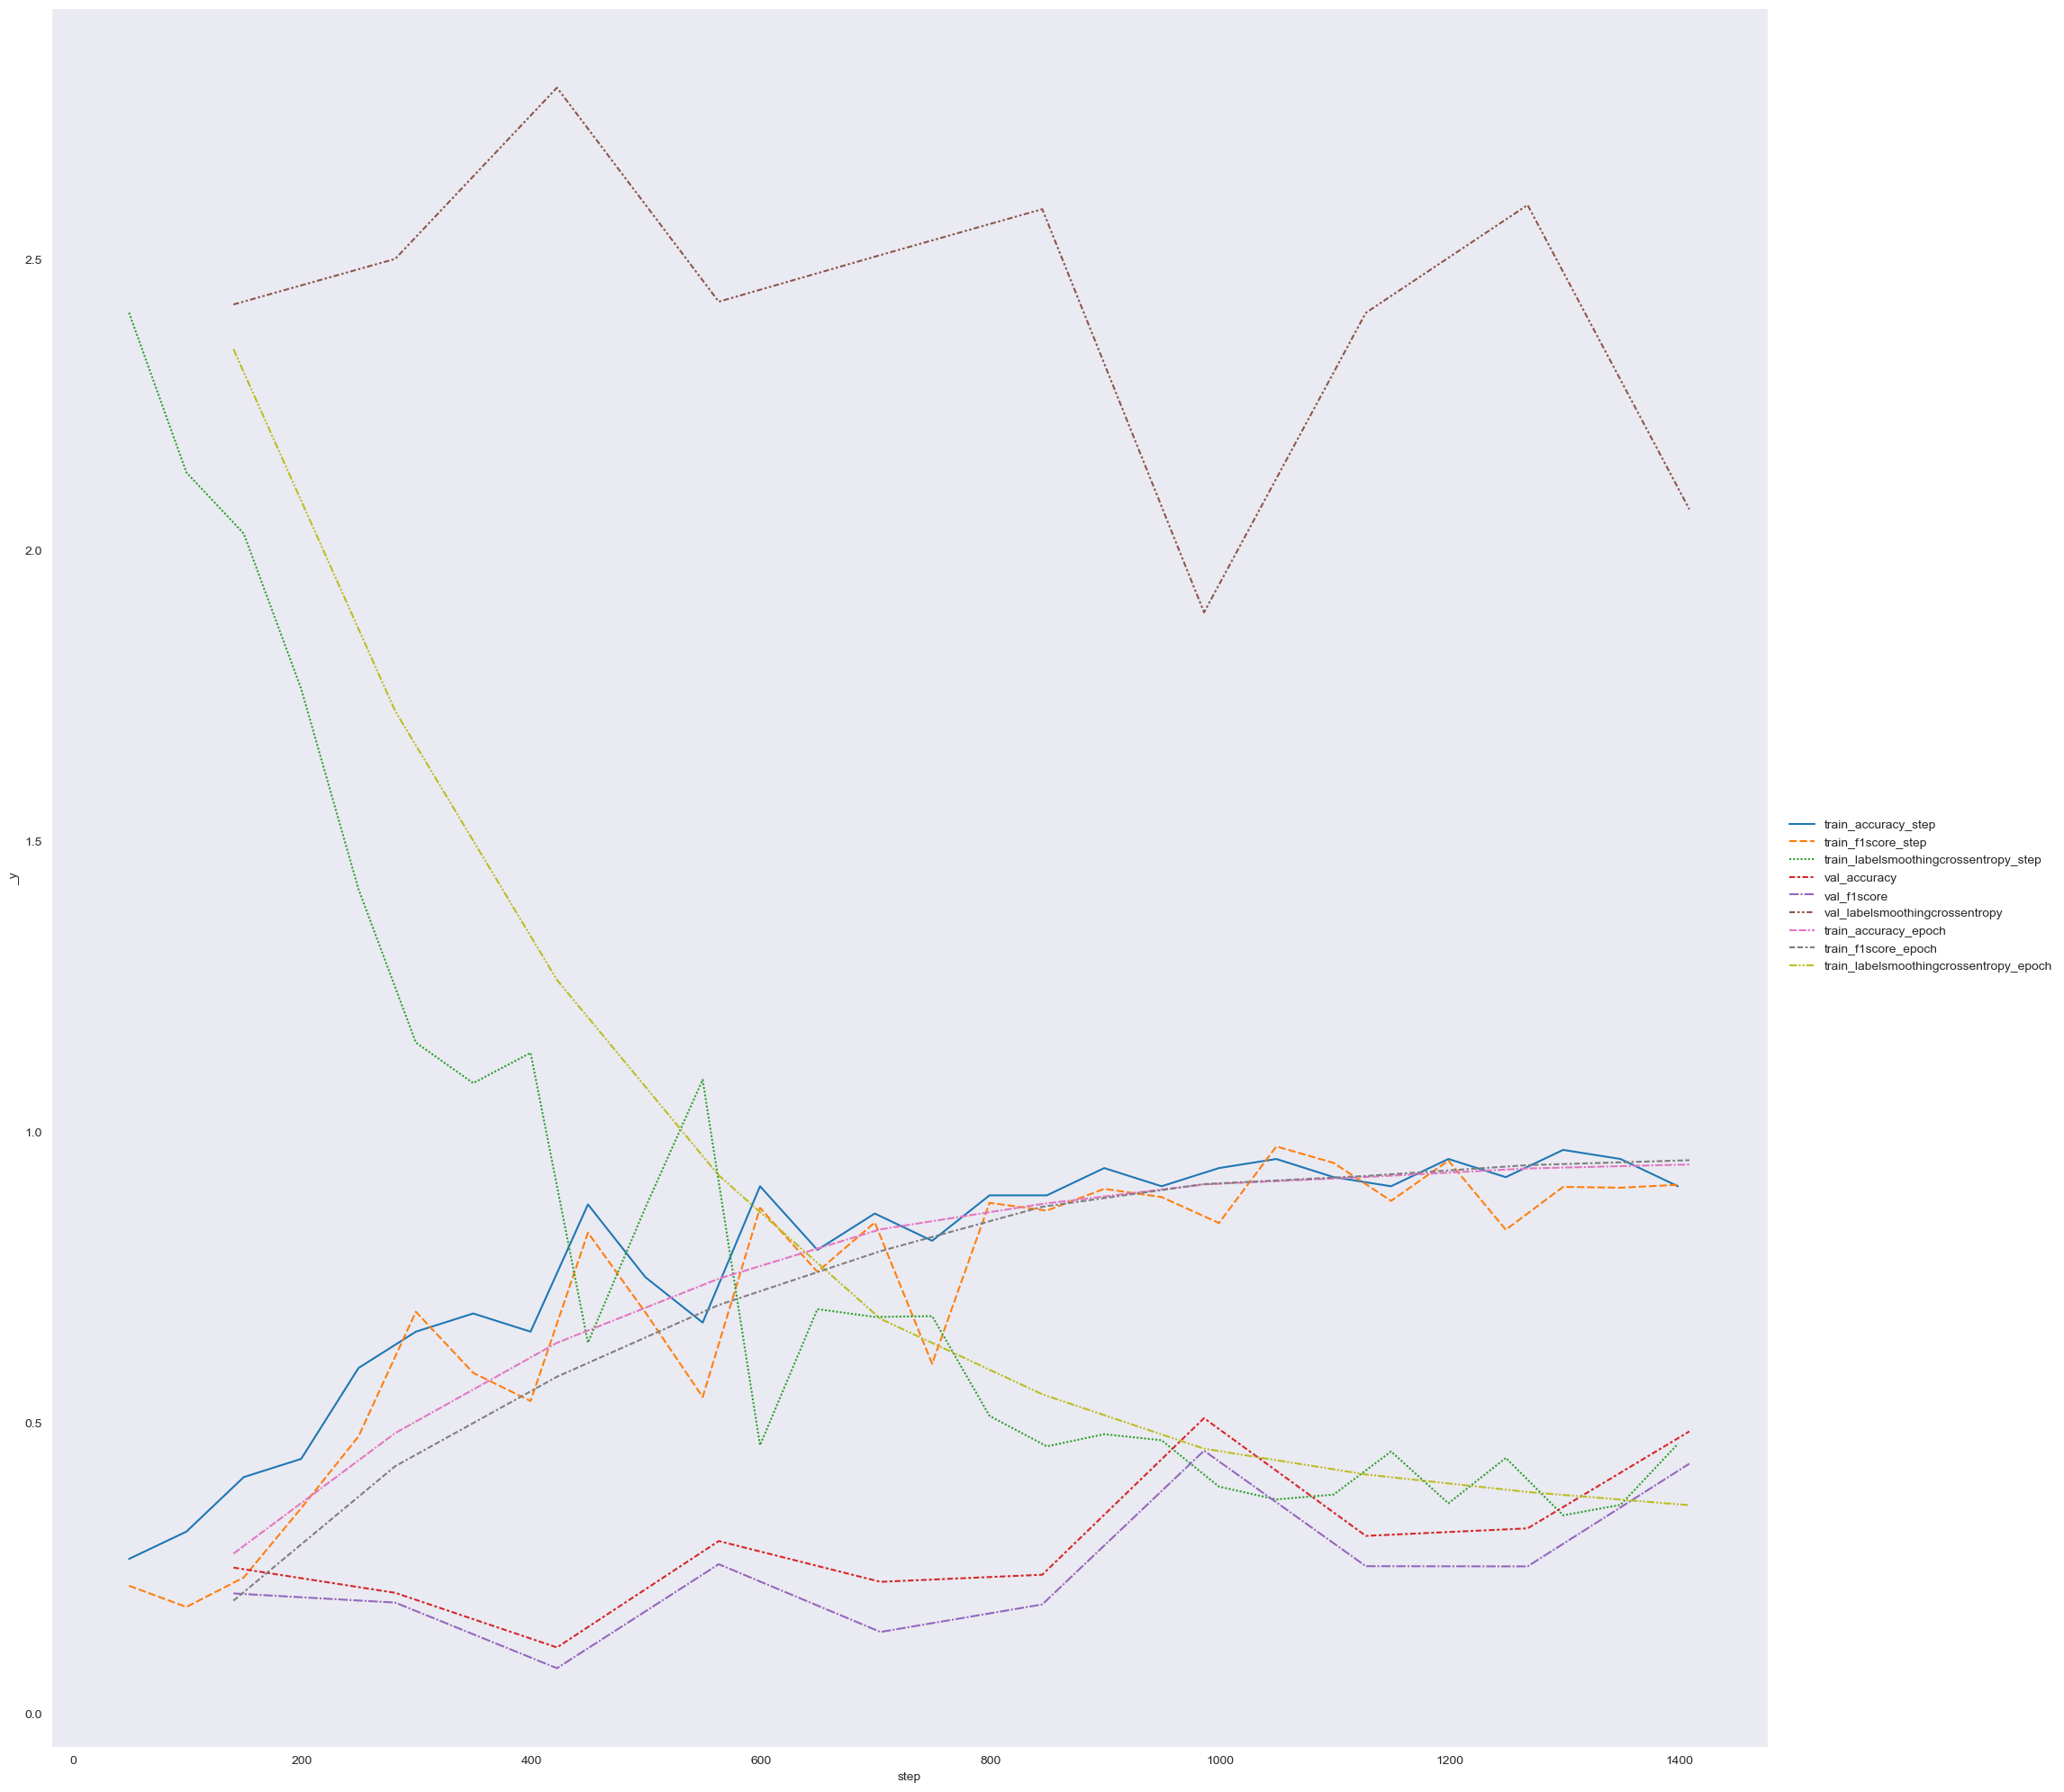

In [58]:
plt.figure(figsize=(20,5))
sns.relplot(data=metrics, kind="line", height=20)
plt.grid()